# Исследование аренды самокатов сервиса GoFast

Нам предоставлены данные о некоторых пользователей сервиса **GoFast** из нескольких городов и об их поездках. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
 * абонентская плата отсутствует;
 * стоимость одной минуты поездки — 8 рублей;
 * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
 * абонентская плата — 199 рублей в месяц;
 * стоимость одной минуты поездки — 6 рублей;
 * стоимость старта — бесплатно.
 
**Цель проекта** - проанализировать данные и провести статистический анализ, проверив некоторые гипотезы, которые помогут бизнесу вырасти.

**Ход исследования**

Данные представлены в нескольких датафреймах:
 * `/datasets/users_go.csv` - данные о пользователях;
 * `/datasets/rides_go.csv` - данные о совершенных ими поездках;
 * `/datasets/subscriptions_go.csv` - данные о подписках.
 
Проведем обзор и предобработку данных, выявим проблемы в данных и опишем возможные причины их появления:
* возможные ошибки (неверный тип данных, названия столбцов);
* наличие дубликатов, пропусков;

Выполним исследовательский анализ, опишем и визуализируем общую информацию о пользователях и поездках. Произведем объединение данных для дальнейшей работы с ними. Проведем подсчет выручки, после чего проверим несколько гипотез, а также сформулируем ответы по вопросам реализации акций и push-уведомлений.

# Оглавление

**[1. Обзор данных](#view)**

**[2. Предобработка данных](#preprocessing)**

&emsp; [2.1. Обработка типов данных](#data_types)

&emsp; [2.2. Обработка дубликатов](#miss_diplicates)

**[3. Исследовательский анализ](#research)**

**[4. Объединение данных](#merging)**

**[5. Подсчет выручки](#gain_count)**

**[6. Проверка гипотез](#hypotheses)**

&emsp; [6.1. Гипотеза о времени поездки](#hypothesis_duration)

&emsp; [6.2. Гипотеза о расстоянии поездки](#hypothesis_distance)

&emsp; [6.3. Гипотеза о выручке](#hypothesis_gain)

&emsp; [6.4. Гипотеза об обновлении сервера](#hypothesis_servers)

**[7 Распределения](#distribution)**

&emsp; [7.1. Распределение акционных подписок](#sub_sale)

&emsp; [7.2. Распределение для push-уведомлений](#push)

**[8. Выводы](#calculations)**

<a id="view"></a>
## Обзор данных

Ознакомимся с данными. Выведем несколько первых строк по каждому датафрейму:

In [1]:
# Импорт необходимых библиотек
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None # Отключение предупреждения о ссылке
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sb
import numpy as np
from math import sqrt

In [2]:
# Считаем данные и выведем первые 5 строк каждого датафрейма
data_users = pd.read_csv('/datasets/users_go.csv')
data_rides = pd.read_csv('/datasets/rides_go.csv')
data_sub = pd.read_csv('/datasets/subscriptions_go.csv')

display(data_users.head())
display(data_rides.head())
display(data_sub)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<a id='round'></a>
Единственное что можно пока что заметить - большое количество знаков после запятой в столбцах `distance` и `duration` датафрейма `rides_go.csv`. Позже округлим их для большей наглядности.

Выведем общую информацию о каждом датафрейме:

In [3]:
# Отобразим общую информацию по датафреймам
data_users.info()
print()
data_rides.info()
print()
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   C

Датафрейм `users_go.csv` объемом 1565 строк содержит информацию об именах, возрасте и городе пользователей, также приведены их id. Каждый из столбцов имеет корректный тип данных. 

В датафрейме `rides_go.csv` приведены данные о дальности, длительности и дате поездок пользователей, имеется столбец с id пользователей. Объем данных 18068 строк, что значительно больше объема `users_go.csv`, скорее всего многие имеющиеся пользователи произвели более одной поездки. Типы данных верные, за исключением столбца `date`, его необходимо в дальнейшем исправить на корректные. 

В последнем датафрейме `subscriptions_go.csv` приведена информация по типу подписки, стоимости минуты аренды, цены начала поездки и ежемесячный платеж по ней. Имеется всего 2 строки, что соответствует двум типам подписки - *free, ultra*. Типы данных верные.

Ни в одной таблице не имеется пропусков в каждом столбце, что облегчает задачу предобработки данных.

<a id="preprocessing"></a>
## Предобработка данных


<a id='data_types'></a>
### Обработка типов данных

Как было сказано [ранее](#round), округлим значения в столбцах `distance` и `duration` датафрейма `rides_go.csv` до 2 знаков после запятой:

In [4]:
# Округлим значения в столбцах 'distance' и 'duration'
data_rides['distance'] = data_rides['distance'].round(2)
data_rides['duration'] = data_rides['duration'].round(2)

Изменим тип данных в столбце `date` датафрейма `rides_go.csv` на *datetime64*:

In [5]:
data_rides['date'] = pd.to_datetime(
    data_rides['date'], format='%Y-%m-%d'
)

Определим, за какой период по времени предоставлены данные:

In [6]:
print(
    'Данные предоставлены за период от',
    data_rides['date'].dt.to_period(freq='D').min(),
    'до',
    data_rides['date'].dt.to_period(freq='D').max())

Данные предоставлены за период от 2021-01-01 до 2021-12-30


Данные предоставлены за период в рамках 2021 года. Можем создать на основе столбца `date` новый столбец с номером месяца:

In [7]:
data_rides['date_month'] = pd.DatetimeIndex(data_rides['date']).month

<a id='miss_diplicates'></a>
### Обработка дубликатов

Пропусков нет, проверим наличие явных дубликатов в столбце `user_id` и полных дубликатов в датафрейме `rides_go.csv`. Сначала выведем явные дубликаты и удалим их:

In [8]:
# Посчитаем количество явных дубликатов
print('Количество дубликатов в столбце "user_id":',
      data_users['user_id'].duplicated().sum())

# Удалим все строки, где есть дубликаты в столбце 'user_id'
data_users = data_users.drop_duplicates(subset='user_id').reset_index(drop=True)

Количество дубликатов в столбце "user_id": 31


Проверим полные дубликаты в `rides_go.csv` и удалим их, если такие есть:

In [9]:
# Посчитаем количество полных дубликатов
print('Количество полных дубликатов в датафрейме "rides_go.csv":',
      data_rides.duplicated().sum())

# Удалим все строки, где есть дубликаты в столбце 'user_id'
data_rides = data_rides.drop_duplicates().reset_index(drop=True)

Количество полных дубликатов в датафрейме "rides_go.csv": 0


Определим количество неявных дубликатов в столбце `city` датафрейма `users_go.csv`. Выведем количество уникальных значений столбца `city`:

In [10]:
data_users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Неявных и полных дубликатов нет, явные обработаны, пропусков не наблюдали - можем идти дальше.

<a id='research'></a>
## Исследовательский анализ

Изобразим столбчатую диаграмму, на которой покажем количество пользователей в разных городах:

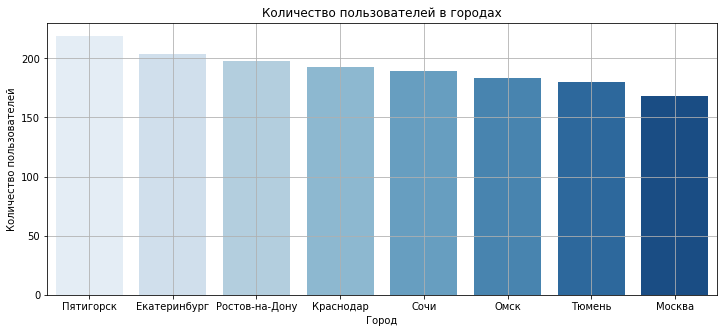

In [11]:
plt.figure(figsize=(12, 5))
sb.countplot(
    x='city', 
    data = data_users,
    palette='Blues',
    order=data_users['city'].value_counts(ascending=False).index
).set_xlabel('Город')
plt.ylabel('Количество пользователей')
plt.title('Количество пользователей в городах')
plt.grid(True)
plt.show()

Все города встречаются примерно одинаковое количество раз, однако необычно, что данных из Москвы меньше всего. Изобразим круговую диаграмму по пользователям с подпиской и без нее:

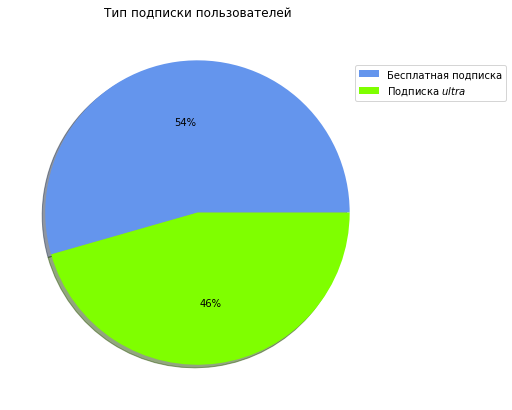

In [12]:
data_users.pivot_table(
    index='subscription_type', values='user_id', aggfunc='count'
).plot(
    kind='pie',
    y='user_id',
    title='Тип подписки пользователей',
    ylabel='',
    shadow=True,
    autopct='%1.0f%%',
    colors=['cornflowerblue', 'chartreuse'],
    figsize=(7, 7),
    labels=['', '']
)
plt.legend(bbox_to_anchor = (0.9, 0.9),
           labels=['Бесплатная подписка', 'Подписка $ultra$'])
plt.show()

Большая часть пользователей не используют платную подписку `ultra`, однако оба типа подписки встречаются среди пользователей часто, что является достаточно типичной ситуацией. 

Далее будут рассмотрены количественные данные. Выведем на экран таблицу характерных значений для распределения количественных данных (возраста, дальности поездки и ее длительности). Также изобразим гистограмму, на которой отобразим возраста пользователей:

,distance,duration,age
count,18068.000000,18068.000000,1534.000000
mean,3070.659992,17.805017,24.903520
std,1116.831222,6.091071,4.572367
min,0.860000,0.500000,12.000000
25%,2543.227500,13.600000,22.000000
50%,3133.610000,17.680000,25.000000
75%,3776.220000,21.722500,28.000000
max,7211.010000,40.820000,43.000000


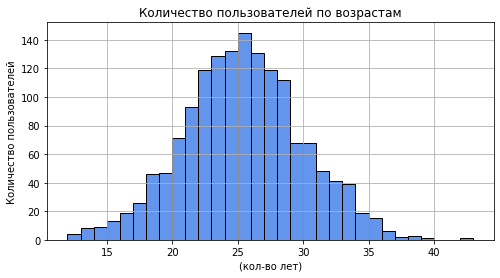

In [13]:
# Выведем таблицу характерных значений
display(
    data_rides[['distance', 'duration']].describe().join(data_users['age'].describe())
)

# Выведем гистограмму количества пользователей по возрастам
data_users.plot(
    kind='hist',
    y='age',
    bins=data_users['age'].max() - data_users['age'].min(),
    title='Количество пользователей по возрастам',
    legend=False,
    edgecolor='black',
    color='cornflowerblue',
    grid=True,
    figsize=(8, 4)
)
plt.ylabel('Количество пользователей')
plt.xlabel('(кол-во лет)')
plt.show()

Распределение возраста пользователей очень напоминает нормальное с пиком 25 лет. Пользователей старше 40 лет практически не встречается. Изобразим гистограмму по расстоянию, которое преодолел пользователь за поездку:

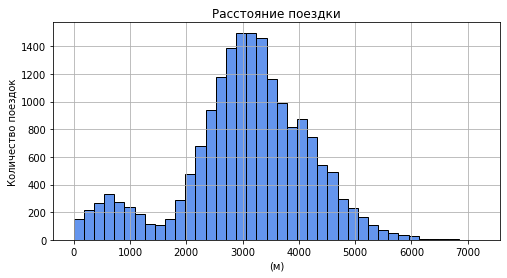

In [14]:
data_rides.plot(
    kind='hist',
    y='distance',
    bins=40,
    title='Расстояние поездки',
    legend=False,
    edgecolor='black',
    color='cornflowerblue',
    grid=True,
    figsize=(8, 4)
)
plt.ylabel('Количество поездок')
plt.xlabel('(м)')
plt.show()

Наблюдаем два пика на распределении:
* в районе 600 метров (слишком короткие поездки)
* в районе 3000 метров (обычные поездки)

<a id='theory'></a>
Есть предположение, что наличие второго пика может быть связано с платной подпиской, которая позволяет бесплатно начинать поездку, поэтому пользователь может брать в аренду самокат даже на незначительные расстояния без потери "лишних" средств. Отсутствие подписки обязывает вносить плату за начало аренды, поэтому пользователь постарается совершить более длинную поездку. Проверим это предположение [позже](#too_short). Изобразим гистограмму по длительности поездки:

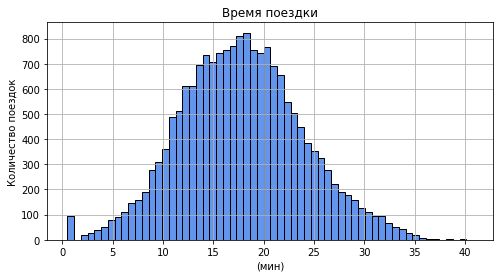

In [15]:
data_rides.plot(
    kind='hist',
    y='duration',
    bins=60,
    title='Время поездки',
    legend=False,
    edgecolor='black',
    color='cornflowerblue',
    grid=True,
    figsize=(8, 4)
)
plt.ylabel('Количество поездок')
plt.xlabel('(мин)')
plt.show()

Чаще всего поедки завершают за 18 минут, время поездок распределено нормально. наблюдается небольшой пик возле 1 минуты. Очень похоже на отмену поездки сразу после ее начала. Причиной мог выступить человеческий фактор - человек не разобрался в интерфейсе мобильного приложения и решил отменить поездку. Технические неполадки в самом приложении могли послужить причинами такого пика, также человеку мог попасться севший, грязный или дефектный самокат.

<a id='merging'></a>
## Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм для удобства дальнейшего анализа, также создадим новый столбец `speed_avg`, в который поместим средние скорости во время поездки поделив столбец `distance` на столбец `duration`. Также переведем скорость в привычную размерность - км/ч и произведем проверку объединения - совпадает ли количество строк наибольшей таблицы (таблица с поездками) с количеством строк в объединенной таблице. Также проверим количество пропусков

In [16]:
# Объединим методом merge
data_full = data_rides.merge(data_users, on='user_id')
data_full = data_full.merge(data_sub, on='subscription_type')

# Создадим столбец со скоростями
data_full['speed_avg'] = (data_full['distance'] / data_full['duration']) * 60 / 1000

# Выведем первые 5 строк для ознакомления
display(data_full.head())

# Произведем проверку объединения наглядно
print('Сумма строк в двух таблицах:', data_rides.shape[0])
print('Количество строк в объединенной таблице:', data_full.shape[0])
print()

print('Количество пропусков в объединенном датафрейме:')
data_full.isna().sum()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,speed_avg
0,1,4409.92,25.60,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199,10.335750
1,1,2617.59,15.82,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199,9.927649
2,1,754.16,6.23,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199,7.263178
3,1,2694.78,18.51,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199,8.735105
4,1,4028.69,26.27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199,9.201424


Сумма строк в двух таблицах: 18068
Количество строк в объединенной таблице: 18068

Количество пропусков в объединенном датафрейме:


user_id              0
distance             0
duration             0
date                 0
date_month           0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
speed_avg            0
dtype: int64

len(data_full)

Количество строк совпало, объединение выполнено корректно. Изобразим гистограмму средних скоростей:

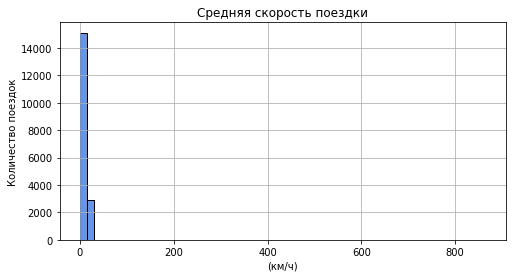

In [17]:
data_full.plot(
    kind='hist',
    y='speed_avg',
    bins=60,
    title='Средняя скорость поездки',
    legend=False,
    edgecolor='black',
    color='cornflowerblue',
    grid=True,
    figsize=(8, 4)
)
plt.ylabel('Количество поездок')
plt.xlabel('(км/ч)')
plt.show()

Определенно что-то не так с данными, таких значений средних скоростей явно не может достичь электрический самокат. Посмотрим на значения столбцов ` duration`, `distance` и `speed_avg` там, где средняя скорость больше типичных 25 км/ч:

In [18]:
# Изобразим строки, где скорость превышает 25 км/ч
display(
    data_full[['duration', 'distance', 'speed_avg']].query('speed_avg > 25')
)

# Изобразим долю таких поездок
print(
    'Доля поездок со средней скоростью больше 25 км/ч:',
    len(data_full.query('speed_avg > 25')) / len(data_full)
)

,duration,distance,speed_avg
6531,0.5,4196.45,503.5740
6570,0.5,4830.82,579.6984
6680,0.5,4684.00,562.0800
6695,0.5,5215.64,625.8768
6768,0.5,5197.44,623.6928
...,...,...,...
17004,0.5,5531.34,663.7608
17242,0.5,6724.93,806.9916
17314,0.5,4445.48,533.4576
17505,0.5,5722.55,686.7060


Доля поездок со средней скоростью больше 25 км/ч: 0.005479300420633164


Во всех таких столбцах одинаковое время поездки в пол минуты, что очень подозрительно при таких расстояниях. Возможно специальные сотрудники сервиса **GoFast** перемещали самокаты в зоны, в которых их не хватало, либо на зарядную станцию или по иной другой причине и такие перемещения проходят в системе как поездки. Также возможно таким образом была реализована акция для пользователей. Данную информацию необходимо уточнять, прежде чем как то ее обрабатывать. Оставим эти строки как есть. Заново изобразим гистограмму средних скоростей в диапазоне от 0 до 25 км/ч.

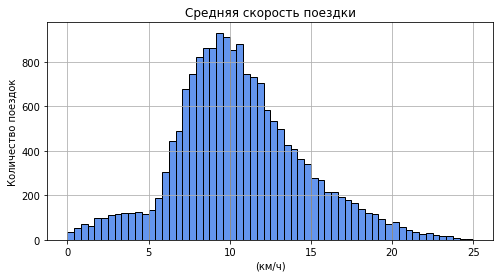

In [19]:
# Изобразим гистограмму средних скоростей
data_full.plot(
    kind='hist',
    y='speed_avg',
    bins=60,
    title='Средняя скорость поездки',
    legend=False,
    edgecolor='black',
    color='cornflowerblue',
    grid=True,
    range=(0, 25),
    figsize=(8, 4)
)
plt.ylabel('Количество поездок')
plt.xlabel('(км/ч)')
plt.show()

<a id='low_speed'></a>
Присутствует достаточно равномерный участок скоростей до 5 км/ч. Такая маленькая скорость может быть обусловлена высокой плотностью людей в зоне поездки.

Создадим два отдельных датафрейма, в которых будет информация только по пользователям с подпиской и без нее:

In [20]:
# Создадим датафрейм с пользователями без подписки
data_free = data_full.query('subscription_type == "free"').reset_index(drop=True)

# Создадим датафрейм с пользователями с подпиской ultra
data_ultra = data_full.query('subscription_type == "ultra"').reset_index(drop=True)

Посмотрим как распределены расстояния поездок среди пользователей с подпиской/без нее:

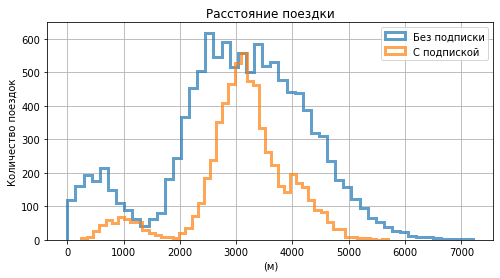

In [21]:
# Создадим функцию построения гистограммы
def double_sub_hist(data_1, data_2, col_name, n, title, xlabel):
    ax = data_1.plot(
        y=col_name,
        kind='hist',
        bins=n,
        histtype='step',
        linewidth=3,
        alpha=0.7,
        figsize=(8,4)
    )

    data_2.plot(
        y=col_name,
        kind='hist',
        bins=n,
        histtype='step',
        linewidth=3,
        ax=ax,
        alpha=0.7,
        grid=True,
        figsize=(8,4)
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Количество поездок')
    plt.legend(['Без подписки', 'С подпиской'])
    plt.show()

# Вызовем функцию построения гистограмм
double_sub_hist(
    data_free, data_ultra, 'distance', 50, 'Расстояние поездки', '(м)'
)    

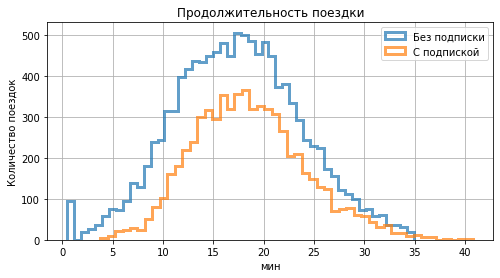

In [22]:
double_sub_hist(
    data_free, data_ultra, 'duration', 50, 'Продолжительность поездки', 'мин'
)    

<a id='too_short'></a>
Озвученное [ранее](#theory) предположение не подтвердилось. "Слишком короткие" поездки присутствуют как среди пользователей с подпиской, так и среди тех, кто ее не приобрел, причем таких поездок больше у последних. 

Короткие поездки, должны быть очень быстрыми, что неизбежно бы вызвало пик на гистограмме времени, однако такого мы не наблюдали. Можем предположить, что такие короткие поездки совершались в очень людных местах, где быстро ездить не получится. Изобразим гистограммы средних скоростей пользователей с обоими видами подписок.

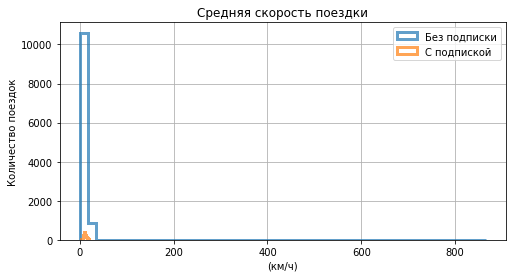

In [23]:
# Вызовем функцию построения гистограмм
double_sub_hist(
    data_free, data_ultra, 'speed_avg', 50, 'Средняя скорость поездки', '(км/ч)'
)    

Не похоже, что наличие подписки как то влияет на скорость перемещения. Видим весомое количество поездок до 5 км/ч. О причинах такого распределения говорили [ранее](#low_speed). Изобразим гистограммы по времени поездки.

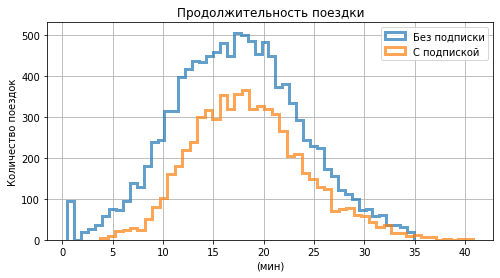

In [24]:
# Вызовем функцию построения гистограмм
double_sub_hist(
    data_free, data_ultra, 'duration', 50, 'Продолжительность поездки', '(мин)'
)    

Характер распределения идентичен у обоих групп пользователей.

<a id='gain_count'></a>
## Подсчет выручки

Создадим новый датафрейм с агрегированными данными по количеству поездок, общей длительности и общему расстоянию поездок за каждый месяц для каждого пользователя. Необходимо создать сводную таблицу с мультииндексом: первым будет id пользователя, вторым будет месяц, в который осуществлялись поездки. Для удобства, после создания таблицы избавимся от мультииндекса. Также округлим значения из столбца `duration` вверх.

In [25]:
# Округлим значение столбца 'duration' вверх
data_full['duration'] = np.ceil(data_full['duration'])

# Создадим сводную таблицу с суммой времени и дальности поездок
data_agg_full = data_full.pivot_table(
    index=['user_id', 'date_month'],
    values=['duration', 'distance'],
    aggfunc='sum'
).reset_index()

# Создадим сводную таблицу для слияния по индексам с общим числом поездок
data_to_join = data_full.pivot_table(
    index=['user_id', 'date_month'],
    values='name',
    aggfunc='count'
).reset_index()['name']

# Объединим исходную таблицу со столбцом общего количества поездок
data_agg_full = data_agg_full.join(data_to_join)

# переименуем столбцы
data_agg_full.columns = ['user_id', 'date_month', 'distance_total', 'duration_total', 'count']

# Выведем первые 5 строк получившегося датафрейма
data_agg_full.head(5)

,user_id,date_month,distance_total,duration_total,count
0,1,1,7027.51,42.0,2
1,1,4,754.16,7.0,1
2,1,8,6723.47,46.0,2
3,1,10,5809.91,32.0,2
4,1,11,7003.50,56.0,3


In [26]:
# код ревьюера

agg_tbl = data_full.groupby(['user_id', 'date_month']).agg({'subscription_type' : 'first'
                                        , 'duration' : 'sum'
                                        , 'distance' : 'sum'
                                        , 'date' : 'count'
                                       }
                                      ).reset_index() # формируем сводную таблицу

rev_table = agg_tbl.merge(data_sub, on='subscription_type') # добавляем данные о тарифах


display(rev_table.head())

,user_id,date_month,subscription_type,duration,distance,date,minute_price,start_ride_price,subscription_fee
0,1,1,ultra,42.0,7027.51,2,6,0,199
1,1,4,ultra,7.0,754.16,1,6,0,199
2,1,8,ultra,46.0,6723.47,2,6,0,199
3,1,10,ultra,32.0,5809.91,2,6,0,199
4,1,11,ultra,56.0,7003.50,3,6,0,199


Подсчитаем ежемесячную выручку для каждого пользователя. Для этого доабвим необходимую информацию о тарифном плане пользователя в сводную таблицу:

In [27]:
# Создадим датафрейм с тарифным планом
data_tariff = data_full.pivot_table(
    index=['user_id', 'date_month'],
    values=['minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type'],
    aggfunc='first'
).reset_index()[['minute_price', 'start_ride_price', 'subscription_fee', 'subscription_type']]

# Объединим сводные таблицы
data_agg_full = data_agg_full.join(data_tariff)
data_agg_full.head()

,user_id,date_month,distance_total,duration_total,count,minute_price,start_ride_price,subscription_fee,subscription_type
0,1,1,7027.51,42.0,2,6,0,199,ultra
1,1,4,754.16,7.0,1,6,0,199,ultra
2,1,8,6723.47,46.0,2,6,0,199,ultra
3,1,10,5809.91,32.0,2,6,0,199,ultra
4,1,11,7003.50,56.0,3,6,0,199,ultra


Теперь можем посчитать ежемесячную выручку каждого юзера. Она складывается из цены за время аренды, цены за начало поездки и цены подписки:

In [28]:
data_agg_full['gain_month'] = (
    data_agg_full['count'] * data_agg_full['start_ride_price'] +  
    data_agg_full['duration_total'] * data_agg_full['minute_price'] + 
    data_agg_full['subscription_fee']
)
data_agg_full.head()

,user_id,date_month,distance_total,duration_total,count,minute_price,start_ride_price,subscription_fee,subscription_type,gain_month
0,1,1,7027.51,42.0,2,6,0,199,ultra,451.0
1,1,4,754.16,7.0,1,6,0,199,ultra,241.0
2,1,8,6723.47,46.0,2,6,0,199,ultra,475.0
3,1,10,5809.91,32.0,2,6,0,199,ultra,391.0
4,1,11,7003.50,56.0,3,6,0,199,ultra,535.0


<a id='hypotheses'></a>
## Проверка гипотез

<a id='hypothesis_duration'></a>
### Гипотеза о времени поездки

Необходимо понять, как влияет подписка на время пользования самоката. Для этого сформулируем нулевую $(H_0)$ и альтернативную $(H_0)$ гипотезы:

$H_0:$ средние выборочные времена поездок двух выборок равны друг-другу;  
$H_1:$ среднее выборочное время поездки среди пользователей с подпиской больше среднего выборочного времени пользователей без подписки.

Зададимся уровнем статистической значимости $\alpha=0.025$, и найдем *p-value*:

In [29]:
# Зададим уровень статистической значимости

alpha_time = 0.025 # Вдвое меньше типичного значения 0.05, ввиду того, что гипотеза односторонняя

# Найдем p-value. equal_var=False, т.к. выборки слишком отличаются по размеру,
# не можем с уверенностью говорить о равенстве дисперсий

results_time_greater = st.ttest_ind(data_ultra['duration'],
                                    data_free['duration'],
                                    equal_var=False,
                                    alternative='greater')

print('Значение p-value:', results_time_greater.pvalue)

# Проверка гипотезы

if results_time_greater.pvalue < alpha_time:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
    
else:
    print('Не отвергаем нулевую гипотезу')

Значение p-value: 5.6460360110885e-37
Отвергаем нулевую гипотезу в пользу альтернативной


Значение p-value очень мало, поэтому могли взять и более низки уровень статистической значимости - нулевая гипотеза была бы отвергнута все равно. Можем сказать, что пользователи с подпиской вероятнее всего совершают более долгие поездки.

<a id='hypothesis_distance'></a>
### Гипотеза о расстоянии поездки

По предоставленным заказчиком данным, расстояние одной поездки в 3130 метров - оптимальное с точки зрения износа самоката. Необходимо проверить одностороннюю гипотезу, проезжают ли пользователи в среднем меньше данного значения. Произведем проверку среди пользователей с подпиской и без нее. Нулевая гипотеза для обеих выборок будет одинаковая:

$H_0:$ среднее расстояние поездок пользователей равно 3130 метрам;
$H_1:$ среднее расстояние поездок пользователей с подпиской больше 3130 метров.

Зададимся уровнем статистической значимости $\alpha=0.025$, и найдем *p-value* для пользователей с палтной подпиской:

In [30]:
# Зададим уровень статистической значимости

alpha_distance = 0.025 # Вдвое меньше типичного значения 0.05, ввиду того, что гипотеза односторонняя

# Зададим предполагаемое в H0 среднее значение

optimal_distance = 3130

# Найдем p-value для пользователей с платной подпиской

results_distance_greater_ultra = st.ttest_1samp(data_ultra['distance'],
                                                optimal_distance,
                                                alternative='greater')

print('Значение p-value для пользователей с подпиской:', results_distance_greater_ultra.pvalue)

print('Для пользователей с подпиской ', end='')

# Проверка гипотезы для пользователей с платной подпиской

if results_distance_greater_ultra.pvalue < alpha_distance:
    print('отвергаем нулевую гипотезу в пользу альтернативной')
    print()
    
else:
    print('не отвергаем нулевую гипотезу')
    print()
    
# Найдем p-value для пользователей без подписки

results_distance_less_free = st.ttest_1samp(data_free['distance'],
                                            optimal_distance,
                                            alternative='less')

print('Значение p-value для пользователей с подпиской:', results_distance_less_free.pvalue)

print('Для пользователей без подписки ', end='')

# Проверка гипотезы для пользователей без подписки

if results_distance_less_free.pvalue < alpha_distance:
    print('отвергаем нулевую гипотезу в пользу альтернативной')
    
else:
    print('не отвергаем нулевую гипотезу')

Значение p-value для пользователей с подпиской: 0.9195362605842414
Для пользователей с подпиской не отвергаем нулевую гипотезу

Значение p-value для пользователей с подпиской: 1.6095168660822524e-13
Для пользователей без подписки отвергаем нулевую гипотезу в пользу альтернативной


Можем сказать, что пользователи с подпиской в среднем проезжают не более 3130 метров. Реализуем еще один тест - проверим две гипотезы с тем же значением уровня статистической значимости:

$H_0:$ среднее расстояние поездок пользователей с подпиской и без нее - одинаковое.  
$H_1:$ среднее расстояние поездок пользователей без подписки меньше среднего расстояния поездок пользователей с подпиской.  

In [31]:
# Произведем односторонний Т-тест для двух независимых выборок

results_sub_free_distance = st.ttest_ind(data_free['distance'],
                                         data_ultra['distance'],
                                         equal_var=False,
                                         alternative='less')

print('Значение p-value для пользователей с подпиской:', results_sub_free_distance.pvalue)

if results_sub_free_distance.pvalue < alpha_distance:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
    
else:
    print('Не отвергаем нулевую гипотезу')

Значение p-value для пользователей с подпиской: 3.4748798377390786e-06
Отвергаем нулевую гипотезу в пользу альтернативной


Получается пользователи без подписки, с точки зрения износа самоката, более предпочтительны, т.к. они проезжают в среднем меньшее расстояние чем пользователи с подпиской.

<a id='hypothesis_gain'></a>
### Гипотеза о выручке

Проверим, приносят ли пользователи с подпиской большую прибыль. Сформулируем нулевую и альтернативную правостороннюю гипотезы:

$H_0:$ средняя месячная прибыль с обеих групп пользователей одинаковая;  
$H_1:$ средняя месячная прибыль от пользователей с подпиской больше.

Зададимся уровнем статистической значимости $\alpha=0.025$, и найдем *p-value*, также изобразим две гистограммы по выручке:

Значение p-value: 8.473077792319447e-40
Отвергаем нулевую гипотезу в пользу альтернативной


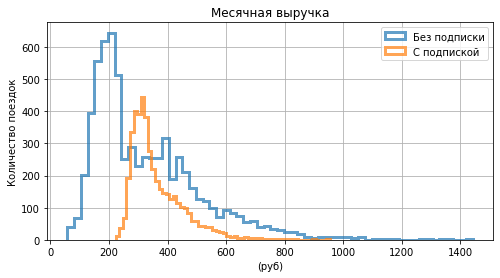

In [32]:
# Зададим уровень статистической значимости
alpha_gain = 0.025 # Вдвое меньше типичного значения 0.05, ввиду того, что гипотеза односторонняя

# Найдем p-value. equal_var=False, т.к. выборки слишком отличаются по размеру,
# не можем с уверенностью говорить о равенстве дисперсий
results_gain_greater = st.ttest_ind(
    data_agg_full.query('subscription_type == "ultra"')['gain_month'], # выборка по пользователям с подпиской
    data_agg_full.query('subscription_type == "free"')['gain_month'], # выборка по пользователям без подписки
    equal_var=False,
    alternative='greater'
)
print('Значение p-value:', results_gain_greater.pvalue)

# Проверка гипотезы
if results_gain_greater.pvalue < alpha_gain:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
    
else:
    print('Не отвергаем нулевую гипотезу')
    
# Вызовем функцию построения гистограмм
double_sub_hist(
    data_agg_full.query('subscription_type == "free"'),
    data_agg_full.query('subscription_type == "ultra"'),
    'gain_month',
    60,
    'Месячная выручка',
    '(руб)'
)    

Пользователи с подпиской явно приносят больше денег, чем те, у кого подписки нет. Очевидно, что необходимо привлекать пользователей к приобретению подписки.

<a id='hypothesis_servers'></a>
### Гипотеза с обновлением серверов

Техническая команда сервиса **GoFast** обновила сервера, надеясь уменьшить число обращений пользователей в техническую поддержку. В некотором файле находится информация о количестве обращений каждого пользователя до и после обновления серверов. Заказчик просит расписать план проверки данной гипотезы.

Для начала можно посмотреть, как численно изменилось общее число обращений в техническую поддержку за выделенный период, также для наглядности можно изобразить гистограмму по количеству обращений до и после обновления. Сформулируем гипотезы:
$H_0:$ Среднее число обращений обеих выборок одинаково;
$H_1:$ Среднее число обращений после обновления серверов меньше, чем среднее число обращений до обновления.

В данной ситуации очевидно, что выборки зависимы, так как обращения исходят от одних и тех же пользователей. В таком случае следует проводить проверку гипотезы о равенстве средних выборочных двух зависимых выборок с помощью метода `ttest_rel` библиотеки `scipy`, передавая ему в качестве аргумента:
* `data_1` - выборка после обновления серверов;
* `data_2` - выборка до обновления серверов;
* `alternative='less'` - альтернативная гипотеза левосторонняя.

Важно, чтобы выборки были одинаковыми по размеру. С помощью данного метода находим p-value, т.е. вероятность получить текущее или более нетипичное значение среднего, сравниваем его с заранее выбранным уровнем статистической значимости. 
```python
# Импорт библиотеки
from scipy import stats as st

# Зададимся уровнем статистической значимости
alpha = 0.025

# Использование метода ttest_rel
results = st.ttest_rel(data_1, data_2, alternative='less')

# Проверяем гипотезу
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')
```

<a id='distribution'></a>
## Распределения

<a id='sub_sale'></a>
### Распределение акционных подписок

Отдел маркетинга собирается провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 человек должны продлить эту подписку. Акция проводилась ранее, по ее результатам было выявлено, что продлевает подписку примерно 10% пользователей. Необходимо найти такое количество участников акции, чтобы с вероятностью $\alpha=95$% план был выполнен.

Акция представляет из себя биномиальный эксперимент, где в результате каждого испытания получаем один из двух возможных результатов: пользователь продлил подписку/пользователь не стал продлевать подписку. Имеем биномиальное распределение вероятностей продления подписки, с вероятностью успеха $p=0.1$, неизвестным числом испытаний.

Можем пойти двумя путями:
* найти число участников с помощью квантиля уровня 1 - $\alpha$ (методом `.ppf()`), так как вероятность $\alpha$ это вероятность получить значение 100 человек или больше, а для квантиля нужно значение вероятности получить 99 человек или меньше;
* найти вероятность с помощью функции распределения вероятности (методом `.cdf()`), однако данная функция возвращает вероятность получения выведенного числа или меньше его. Необходимо вычесть эту вероятность из единицы, чтобы получить обратное.

В последствии можем изобразить столбчатую диаграмму для получившегося распределения.

Вероятность получить минимум 100 новых подписчиков: 0.9492556344605638
Необходимое число участников акции: 1160


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


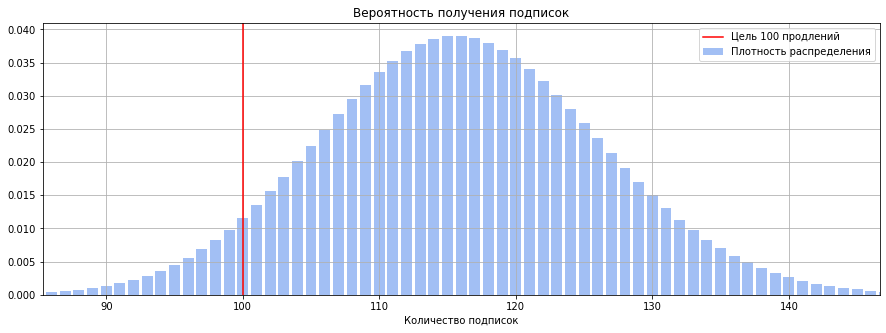

In [33]:
# Запишем вероятность и подберем число участников
p_sub = 0.1
n_sub = 1160

# Зададим целевое значение продлений
sub_purpose = 100

# Найдем матожидание и стандартное отклонение
mu_sub = n_sub * p_sub
sigma_sub = sqrt(n_sub * p_sub * (1 - p_sub))

# Создадим биномиальное распределение на основе вероятности успеха и числа испытаний
distr = st.binom(n_sub, p_sub)

# Определим число участников
print('Вероятность получить минимум 100 новых подписчиков:', 1 - distr.cdf(99))
print('Необходимое число участников акции:', n_sub)

# Построим столбчатую диаграмму
# Для построения необходимо создать список со значениями функции плотности распредления
distr_bar = []

for k in range(0, n_sub + 1):
    current_value = st.binom.pmf(k, n_sub, p_sub)
    distr_bar.append(current_value)
    
plt.figure(figsize=(15, 5))
plt.bar(range(0, n_sub + 1), distr_bar, color='cornflowerblue', alpha=0.6, label='Плотность распределения')
plt.xlabel('Количество подписок')
plt.ylabel('')
plt.xlim(mu_sub - 3 * sigma_sub, mu_sub + 3 * sigma_sub)
plt.title('Вероятность получения подписок')
plt.grid(True)
plt.axvline(sub_purpose, color='r', label='Цель 100 продлений')
plt.legend()
plt.show()


Получено необходимое количество участников акции - 1160 человек.

<a id='push'></a>
### Распределение для push-уведомлений

Отдел ммаркетинга рассылает клиентам push-уведомления. Известно, что уведомления открывает примерно 40% пользователей. Планируется разослать 1 млн уведомлений. Требуется оценить вероятность, что уведомления откроют не более 399.5 тыс. раз.

Аналогично [предыдущему случаю](#sub_sale), тут также представлено биномиальное распределение - юзер откроет уведомление или не откроет с известной вероятностью. Работать с таким объемом данных нецелесообразно, необходима аппроксимация биномиального распределения. Воспользуемся правилом трех сигм и проверим, можно ли аппроксимировать исходное распределение нормальным:

In [35]:
# Запишем количество испытаний и вероятность успеха
n_push = 1e6
p_push = 0.4

# Запишем целевое значение открытий уведомлений
open_purpose = 399.5e3

# Найдем среднее и стандартное отклонение
mu_push = n_push * p_push
sigma_push = sqrt(n_push * p_push * (1 - p_push))

if mu_push - 3 * sigma_push < 0 or mu_push + 3 * sigma_push > n_push:
    print('Аппроксимация невозможна')
else:
    print('Можем аппроксимировать нормальным законом')

Можем аппроксимировать нормальным законом


Отлично, создадим аппроксимированное распределение и изобразим график:

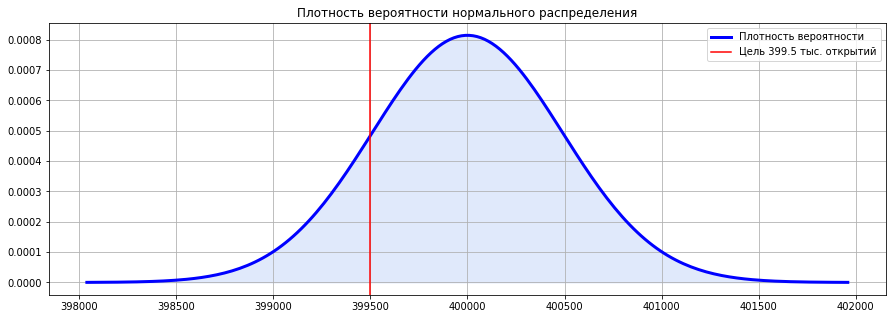

Вероятность того, что push-уведомления откроют не более 399.5 тыс. раз: 0.15371708296369768


In [36]:
def linspace(start, end, num):
    step = (end - start) / (num - 1)
    res = []
    for i in range(num):
        res.append(start + step * i)
    return res

# Создадим границы отображения графика
left = int(mu_push - 4 * sigma_push)
right = int(mu_push + 4 * sigma_push)

# Создадим список значений количества открытых уведомлений
x = linspace(left, right, 200)

# Построим график
plt.figure(figsize=(15,5))
plt.plot(x, st.norm.pdf(x, mu_push, sigma_push), 'b-', lw=3, label='Плотность вероятности')
plt.title('Плотность вероятности нормального распределения')
plt.grid(True)
plt.fill_between(x, st.norm.pdf(x, mu_push, sigma_push), color='cornflowerblue', alpha=0.2)
plt.axvline(open_purpose, color='r', label='Цель 399.5 тыс. открытий')
plt.legend()
plt.show()

# Оценим вероятность получить не меньше 399.5 тысяч открытий уведомлений
distr_push = st.norm(mu_push, sigma_push)

print(
    'Вероятность того, что push-уведомления откроют не более 399.5 тыс. раз:', 
      distr_push.cdf(open_purpose)
)

С вероятностью 15% push-уведомление откроют не более 399.5 тысяч раз.

<a id='calculations'></a>
## Выводы

Было проведено исследование аренды самокатов по данным сервиса **GoFast**. 

Мы изучили общую информацию о полученных данных, в которых находилась информация о пользователях, их поездках и тарифных планах двух подписок - бесплатной и подписки *ultra*. Произвели предобработку данных:
* были выявлены и удалены дубликаты id пользователей в столбце `user_id`
* тип данных в столбце `date` изменен с `object` на корректный `datetime64`

После предобработки были рассмотрены и визуализированы некоторые данные. Посмотрели частоту встречаемости городов, соотношение пользователей с подпиской и без нее. Изучили возраст имеющихся пользователей, расстояние и продолжительность их поездок. Выявили наиболее популярные значения. Также обнаружили аномальные поездки с неправдоподобным временем в пути и описали возможные причины их появления. 

Произвели объединение данных в одну таблицу, ввиду того, что данные были представлены в трех разных CSV файлах. После чего было удобно посмотреть полную информацию и разделить поездки по пользователям с подпиской и без нее. Изобразили совместные гистограммы для обеих групп пользователей по времени поездок, их дальности и средней скорости во время поездки.

На следующем этапе была посчитана ежемесячная выручка от каждого пользователя по агрегированным данным из объединенного датафрейма. 

Ввиду желания продакт-менеджеров повысить число платных подписчиков, провели статистические тесты для проверки влияния подписки на некоторые факторы:
1. Было необходимо понять, тратят ли пользователи с платной подпиской больше времени на аренду самоката.
2. Проезжают ли пользователи из каждой группы в среднем за одну поездку не более 3130 метров, что является оптимальным значением с точки зрения ресурса самоката (данные предосталвены заказчиком).
3. Будет ли помесячная выручка с пользователей с платной подпиской больше, чем без нее;

По каждому из вопросов были сформулированы статистические гипотезы и проведены тесты, результатами которых являются:
* пользователи с платной подпиской в среднем тратят больше времени на аренду;
* пользователи с платной подпиской проезжают за поездку в среднем не больше 3130 метров (дополнительно выяснили, что пользователи без подписки в среднем проезжают меньшее расстояние, чем пользователи с подпиской);
* помесячная выручка с пользователей с подписой в среднем больше, чем с пользователей без нее.

Необходимо было проверить, снизится ли число обращений пользователей в техническую поддержку после обновления серверов. Был расписан алгоритм проведения статистического теста для случая проверки значимости обновления серверов.

В дополнении ко всему, были сформулированы советы для отдела маркетинга по двум вопросам:
* Было определено необходимое число участников в акции по раздаче купонов на бесплатный месяц подписки *ultra*, чтобы в последствие подписку продлило не менее 100 человек с вероятностью выполнить план 95% - 1160 участников.
* Была определена вероятнось, что из разосланных 1 млн push-уведомлений откроют его не более 399.5 тысяч раз - 15%

Таким образом, можем сказать, что необходимо привлекать пользователей к приобретению подписки *ultra*, ввиду большего дохода с таких пользователей. Однако в данном исследовании не учитывался ресурс самокатов - траты на закупку новых. Данный факт следует учитывать ввиду того, что пользователи без подписки в среднем проезжают меньшее расстояние, чем пользователи с подпиской. Выручка зависит напрямую не от расстояния, а от времени аренды, предпочтительнее, чтобы пользователи проезжали как можно меньшее расстояние за как можно большее время (выгодно, чтобы пользователи премещались медленно). Это потенциально уменьшает траты на закупку новых или починку старых самокатов.